# LASSO 
**(Least Absolute Shrinkage and Selection Operator) -L1 regularization-**
- L2 primero reduce los pesos con magnitudes altas por que para mismo delta de reducción, si la magnitud es alta, la reducción es mayor. L1 en cambio por ser lineal da igual si la magnitud es alta o baja.
- L2 no da "sparsity" va bajando todos al mismo tiempo.
- Selector de parametros (Feature selection) - Puede tratar los pesos en forma independiente. Cuando un peso es cero, No importa la relación con el resto como en L2. Sí depende de la función de costo
- $g(w) = \|w\|$ 
- Sparse solution

<img src="https://github.com/diplomatura-deep-learning/Regularizacion/blob/master/images/lasso.png?raw=1" alt="Drawing" style="width:60%;"/>

# LASSO vs RIDGE

In [1]:
from sklearn.linear_model import Lasso, Ridge
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def get_lin_reg_pol(data, order=1, normalize=True, mean = 0, std = 1):
    data_rep = np.repeat(data.reshape(-1,1), order+1, axis=1)
    exps = [i for i in range(order+1)]
    data_all = np.power(data_rep, exps)
    if normalize:
        mean = data_all.mean(axis=0)[1:]
        std = data_all.std(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:] - data_all.mean(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:]/data_all.std(axis=0)[1:]
        return data_all, mean, std
    else:
        data_all[:, 1:] = data_all[:, 1:] - mean
        data_all[:, 1:] = data_all[:, 1:]/std
        return data_all

def get_ridge_weights(alturas, pesos, lamb = 0.1):
    ident = np.matrix(np.identity(alturas.shape[1]))
    X = np.matrix(alturas)
    y = np.matrix(pesos).T
    wRR = (lamb*ident + X.T*X)**-1*X.T*y
    return wRR

def get_MLE_MAP_weights(alturas_pol, pesos, order = 3, lamb = 0.1, N = 20):
    # Devuelve dos arrays con los pesos de MAP y MLE
    ident = np.matrix(np.identity(order+1))
    WMLs = []
    WRRs = []
    for i in range(int(np.floor(len(pesos)/N))):
        X = np.matrix(alturas_pol[i*N:(i+1)*N])
        y = np.matrix(pesos[i*N:(i+1)*N]).T
        wML = ((X.T.dot(X))**-1*X.T)*y
        WMLs = WMLs + [wML.tolist()]
        wRR = (lamb*ident + X.T*X)**-1*X.T*y
        WRRs = WRRs + [wRR.tolist()]
        #print(i, len(y))
    WMLs = np.array(WMLs).reshape(-1,order+1)
    WRRs = np.array(WRRs).reshape(-1,order+1)
    return WMLs, WRRs

def plt_lin_reg_gauss(alturas, pesos, WML, sigma, Xmin, Xmax, Ymin, Ymax, order, mean, std, points = 100, ax=None):
    X = np.linspace(Xmin, Xmax, points)
    Y = np.linspace(Ymin, Ymax, points)
    X, Y = np.meshgrid(X, Y)
    Xr = X.reshape(-1)
    Yr = Y.reshape(-1)
    Y_est = get_lin_reg_pol(Xr, order, normalize=False, mean=mean, std=std).dot(WML)
    Z = norm.pdf(Yr - Y_est, 0, sigma).reshape(points, points)
    Z_points = norm.pdf(pesos - get_lin_reg_pol(alturas, order, normalize=False, mean=mean, std=std).dot(WML),0 , sigma)
    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
    ax.contour3D(X, Y, Z, 512)
    ax.scatter3D(alturas, pesos, Z_points, color='r', marker='o')
    ax.view_init(65,-120)
    plt.show()

def get_curves(alturas_pol, pesos, al_min, al_max, mean, std, order = 3, N=20, lamb = 1, ptos = 100):
    WMLs, WRRs = get_MLE_MAP_weights(alturas_pol, pesos, order = order, lamb = lamb, N = N)
    al = np.linspace(al_min, al_max,ptos)
    al_lin_pol = get_lin_reg_pol(al, order, normalize=False, mean=mean, std=std)
    curv_MLE = np.zeros([len(WMLs), ptos])
    curv_MAP = np.zeros([len(WRRs), ptos])
    for i, w in enumerate(WMLs):
        curv_MLE[i] = al_lin_pol.dot(w)
    for i, w in enumerate(WRRs):
        curv_MAP[i] = al_lin_pol.dot(w)
    return curv_MLE, curv_MAP

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/LCaravaggio/AnalisisPredictivo/master/05_Otros_Regresi%C3%B3n/data/alturas-pesos-mils-train.csv')
data = df[['Altura', 'Peso']].values

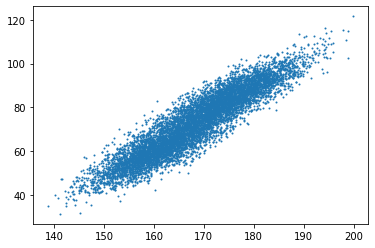

In [4]:
plt.scatter(data[:,0], data[:,1], s=1)
plt.show()

# Ejemplo con polinomio de orden 7 tomando de a 20 observaciones

In [5]:
N = 20 # Cantidad de observaciones
i_sel = 3 # Tomadas de a N cual de las 8000/N tomo
order = 7 # Orden del polinomio
ptos=100 # Resolución de recta
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
alturas_pol, mean, std = get_lin_reg_pol(data[:,0], order, normalize=True)

### Alpha es lambda (Notación Sklearn)

In [6]:
alphas = np.logspace(-3, 3, 100)

In [7]:
w_MSE = get_ridge_weights(alturas_pol[i_sel*N:(i_sel+1)*N, :], data[:,1][i_sel*N:(i_sel+1)*N], lamb = 0).reshape(1,-1)

In [8]:
w_MSE.T.shape

(8, 1)

In [9]:
ws_RIDGE = np.zeros([len(alphas), order+1])
ws_LASSO = np.zeros([len(alphas), order+1])
for i, alpha in enumerate(alphas):
    clf_ridge = Ridge(alpha = alpha, fit_intercept=False)
    clf_ridge.fit(alturas_pol[i_sel*N:(i_sel+1)*N, :], data[:,1][i_sel*N:(i_sel+1)*N])
    w_RIDGE = np.array(list(clf_ridge.coef_))
    w_RIDGE = get_ridge_weights(alturas_pol[i_sel*N:(i_sel+1)*N, :], data[:,1][i_sel*N:(i_sel+1)*N], lamb = alpha).reshape(1,-1)
    clf_lasso = Lasso(alpha = alpha, fit_intercept=False, tol=0.0001, max_iter=100000)
    clf_lasso.fit(alturas_pol[i_sel*N:(i_sel+1)*N, :], data[:,1][i_sel*N:(i_sel+1)*N])
    w_LASSO = np.array(list(clf_lasso.coef_))
    ws_RIDGE[i,:] = w_RIDGE
    ws_LASSO[i,:] = w_LASSO

### Aclaración: No estoy graficando el intercept

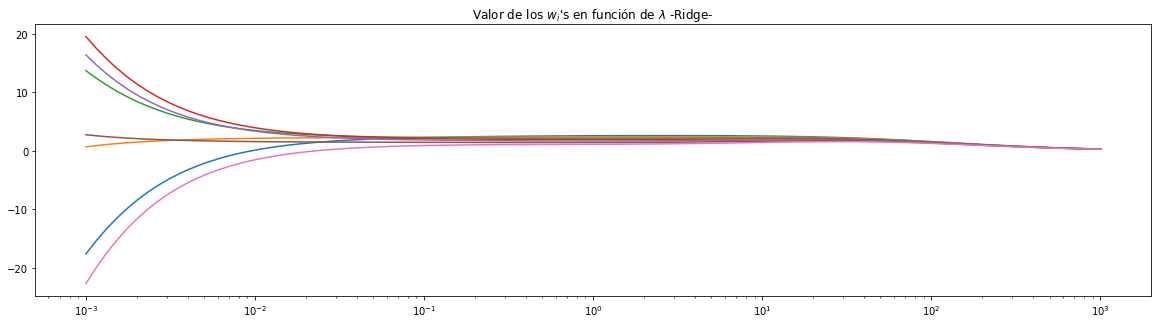

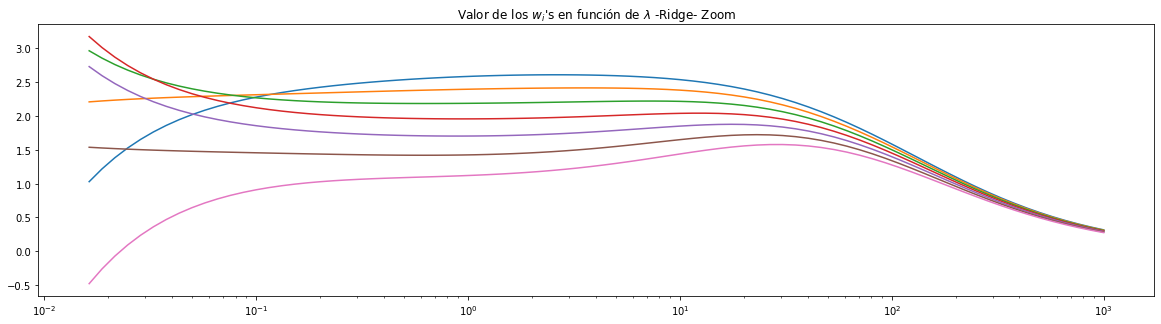

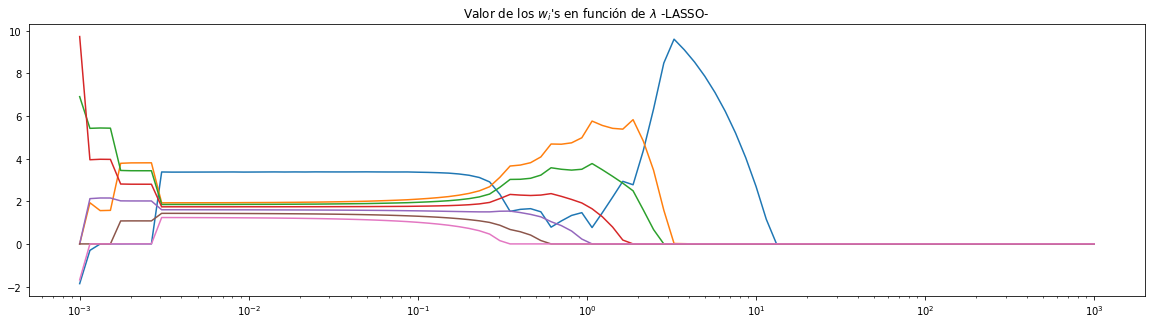

In [10]:
plt.figure(figsize=(20,5))
plt.semilogx(alphas, ws_RIDGE[:,1:])
plt.title("Valor de los $w_i$'s en función de $\lambda$ -Ridge-")
plt.show()

plt.figure(figsize=(20,5))
plt.semilogx(alphas[20:], ws_RIDGE[20:,1:])
plt.title("Valor de los $w_i$'s en función de $\lambda$ -Ridge- Zoom")
plt.show()

plt.figure(figsize=(20,5))
plt.semilogx(alphas, ws_LASSO[:,1:])
plt.title("Valor de los $w_i$'s en función de $\lambda$ -LASSO- ")
plt.show()

Notar en la gráfica superior como algunos pesos se van a cero (Sparsity)

In [11]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(data[:,0][i_sel*N:(i_sel+1)*N].reshape(-1,1), data[:,1][i_sel*N:(i_sel+1)*N])
w_LR = np.array([clf.intercept_, clf.coef_[0]]).reshape(2,1)
print(w_LR)
pe_LR = get_lin_reg_pol(al, normalize=False, order=1).dot(w_LR)

[[-149.97260248]
 [   1.32208121]]


# Regresión de ridge en función de lambda

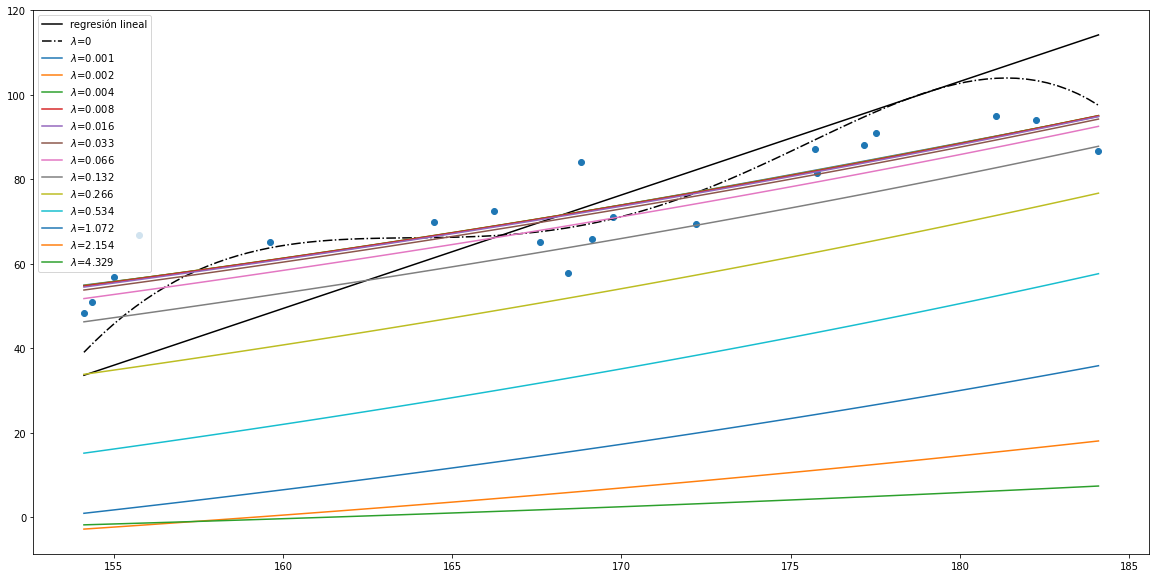

In [12]:
plt.figure(figsize=(20,10))
al = np.linspace(data[:,0][i_sel*N:(i_sel+1)*N].min(),data[:,0][i_sel*N:(i_sel+1)*N].max(), ptos)
al_line = get_lin_reg_pol(al, normalize=False, order=order, mean=mean, std=std)
paso = 8
plt.plot(al, pe_LR, 'k', label='regresión lineal')
plt.plot(al, al_line.dot(w_MSE.T), 'k', ls='-.',label='$\lambda$=0')
for i, w in enumerate(ws_RIDGE[::paso]):
    pe_RIDGE = al_line.dot(w)
    plt.plot(al, pe_RIDGE, label='$\lambda$='+str(np.round(alphas[i*5]*1000)/1000))

plt.legend()
plt.scatter(data[:,0][i_sel*N:(i_sel+1)*N], data[:,1][i_sel*N:(i_sel+1)*N])
plt.show()

Se ve claramente el aumento de bias con el aumento de lambda

# Regresión L1 en función de lambda

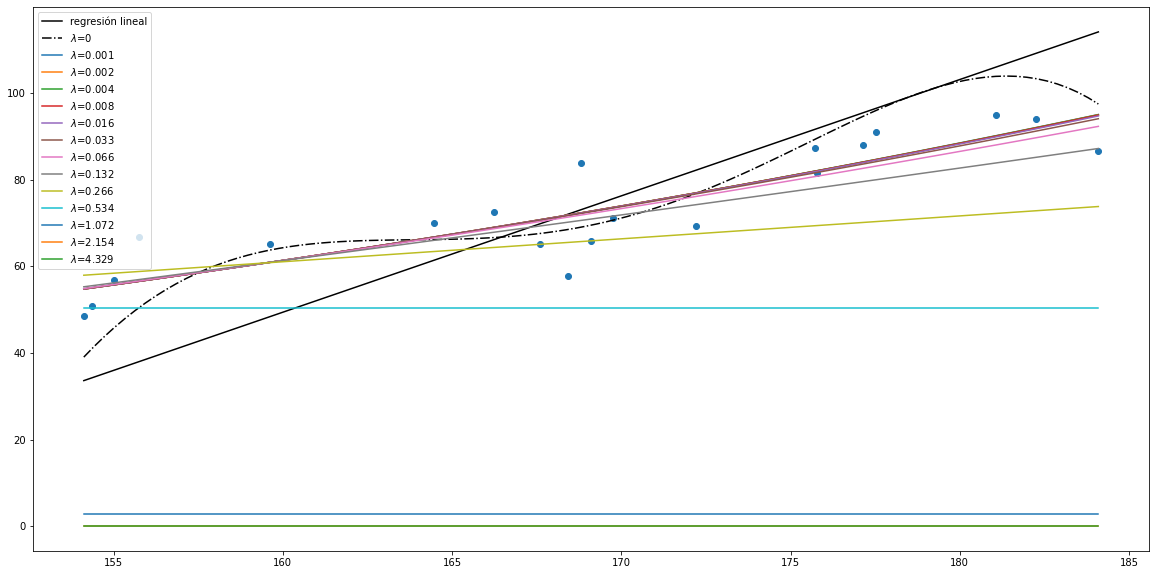

In [13]:
plt.figure(figsize=(20,10))
al_line = get_lin_reg_pol(al, normalize=False, order=order, mean=mean, std=std)
paso = 8
plt.plot(al, pe_LR, 'k', label='regresión lineal')
plt.plot(al, al_line.dot(w_MSE.T), 'k', ls='-.',label='$\lambda$=0')
for i, w in enumerate(ws_LASSO[::paso]):
    pe_LASSO = al_line.dot(w)
    plt.plot(al, pe_LASSO, label='$\lambda$='+str(np.round(alphas[i*5]*1000)/1000))

plt.legend()
plt.scatter(data[:,0][i_sel*N:(i_sel+1)*N], data[:,1][i_sel*N:(i_sel+1)*N])
plt.show()

# ElasticNet
-  Combinacion de L1 y L2

# 4.4 Sparcity y LO regularization:

$w_{RR} = arg \min\| \hat{y}-y_i \|^2 + \lambda \|w\|^d$

- L0 cuenta la cantidad de $w$'s distinto de cero (d=0)
- Si d esta entre 0 y 1 aumenta la esparcibidad (sparsity) pero la funcion de costo no es convexa